In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import re
import time

from src.mazeworld import LimitedCollectMazeWorld, AutoCollectMazeWord, WallAutoCollectMazeWorld
from src.mdp import MDP, LegibleTaskMDP, LearnerMDP
from tqdm import tqdm
from itertools import combinations
%matplotlib notebook

In [2]:
def get_goal_states(states, goal):

    state_lst = list(states)
    return [state_lst.index(x) for x in states if x.find(goal) != -1]

def simulate(mdp, pol, mdp_tasks, leg_pol, x0, n_trajs):

    mdp_trajs = []
    tasks_trajs = []

    for _ in tqdm(range(n_trajs), desc='Simulate Trajectories'):
        traj, acts = mdp.trajectory(x0, pol)
        traj_leg, acts_leg = mdp_tasks.trajectory(x0, leg_pol)
        mdp_trajs += [[traj, acts]]
        tasks_trajs += [[traj_leg, acts_leg]]

    mdp_r = mdp.trajectory_reward(mdp_trajs)
    mdp_rl = mdp_tasks.trajectory_reward(mdp_trajs)
    task_r = mdp.trajectory_reward(tasks_trajs)
    task_rl = mdp_tasks.trajectory_reward(tasks_trajs)

    return mdp_r, mdp_rl, task_r, task_rl

In [3]:
def create_world_view(n_rows, n_cols, obj_place, walls=None):
    
    fig = plt.figure(figsize=(8, 8))
    plt.xlim(0, n_cols)
    plt.ylim(0,  n_rows)
    plt.xticks([i+1 for i in range(n_cols)])
    plt.yticks([i+1 for i in range(n_rows)])
    plt.grid(True)

    for obj in obj_place:
        x = obj[1] - 0.5
        y = obj[0] - 0.5
        o = '$' + obj[2] + '$'
        
        plt.plot(x, y, marker=o, color='k', markersize=10)
    
    if walls:
        for wall in walls:
            wall_sec = np.array([list(wall_elem) for wall_elem in wall])
            plt.plot(wall_sec[:, 1] - 0.5, wall_sec[:, 0] - 0.5, color='k', linewidth=5)
    
    return fig


def visualize_trajectory(x0, trajectory, figure, color):
    action = {'U': (0, -1), 'D': (0, 1), 'L':(-1, 0), 'R':(1, 0), 'G': (0, 0), 'P':(0, 0)}
    plt.plot(x0[0]-0.5, x0[1]-0.5, marker='x', markersize=15, color='gold')
    for ptr in trajectory:
        x = ptr[0]-0.5
        y = ptr[1]-0.5
        a = action[ptr[2]]
        plt.arrow(x, y, a[0], a[1], head_width=0.1, head_length=0.1, lw=1.5, fc=color, ec=color)

        
def process_trajectory(trajectory, actions):
    
    traj = []
    
    for i in range(len(trajectory) - 1):
        state_split = re.match(r"([0-9]+) ([0-9]+) ([a-z]+)", trajectory[i], re.I)
        y = int(state_split.group(1))
        x = int(state_split.group(2))
        o = state_split.group(3)
        
        traj += [(x, y, actions[i])]
    
    return traj

In [4]:
n_rows = 8
n_cols = 8
# objs_states = [(1, 4, 'P'), (3, 1, 'D'), (3, 3, 'C')]
# objs_states = [(2, 1, 'P')]
objs_states = [(6, 4, 'P'), (4, 7, 'D'), (5, 2, 'C'), (8, 1, 'L'), (6, 5, 'T'), (8, 7, 'O')]
# objs_states = [(7, 2, 'P'), (4, 13, 'D'), (6, 9, 'C'), (2, 4, 'L'), (5, 1, 'T'), (9, 10, 'O'), (10, 15,'E'),
#                (1, 14,'A')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)],
         [(0.5, 2.5), (1.5, 2.5)], 
         # [(2.5, 0.5), (2.5, 1.5)], 
         [(2.5, x + 0.5) for x in range(1, 5)],
         [(2.5, x + 0.5) for x in range(5, 8)],
         [(x + 0.5, 4.5) for x in range(2, 7)],
         [(x + 0.5, 4.5) for x in range(7, 9)],
         [(5.5, x + 0.5) for x in range(4, 6)],
         [(5.5, x + 0.5) for x in range(6, 8)],
         [(x + 0.5, 7.5) for x in range(1, 5)],
         [(x + 0.5, 7.5) for x in range(5, 8)]]
# x0 = np.random.choice([x for x in X_a if 'N' in x])
x0 = '1 1 N'
# goals = ['PDT', 'PTO', 'DLC', 'DLT', 'DTO', 'CTO', 'PLO', 'PCO', 'PDO']
goals = ['P', 'D', 'C', 'L', 'T', 'O']
# goals = ['P', 'D', 'C']
# goal = 'PDO'
goal = 'T'

<IPython.core.display.Javascript object>


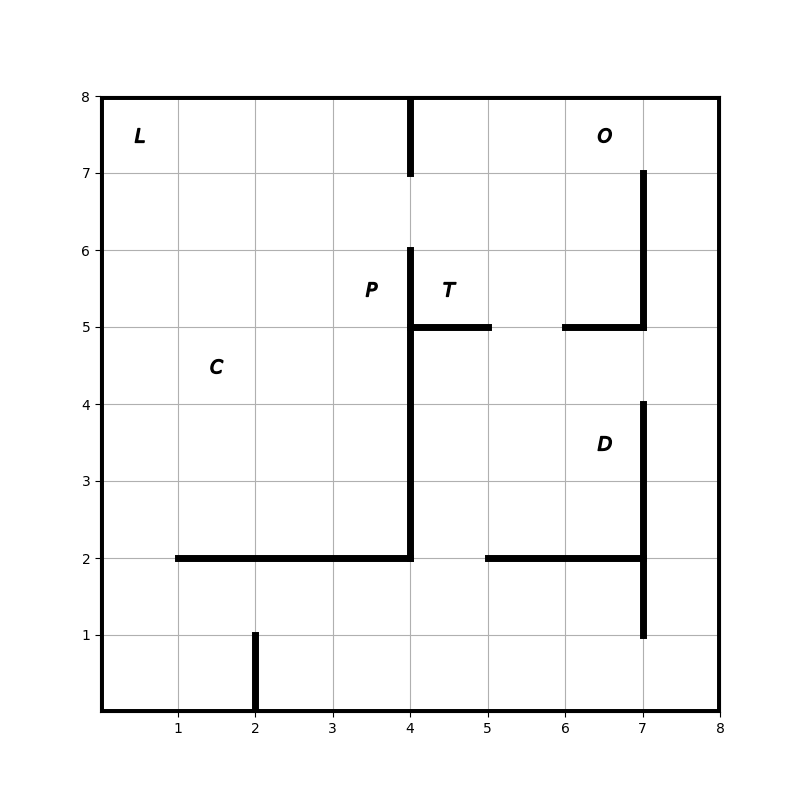

In [5]:
fig = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [6]:
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')
wacmw = WallAutoCollectMazeWorld()
X_w, A_w, P_w = wacmw.generate_world(n_rows, n_cols, objs_states, walls)

print('### Computing Costs and Creating Task MDPs ###')
mdps_w = {}
q_mdps_w = []
task_mdps_w = {}
costs = []
for i in tqdm(range(len(goals)), desc='Single Task MDPs'):
    c = wacmw.generate_costs_varied(goals[i], X_w, A_w, P_w)
    costs += [c]
    mdp = MDP(X_w, A_w, P_w, c, 0.9, get_goal_states(X_w, goals[i]))
    _, q = mdp.policy_iteration()
    q_mdps_w += [q]
    mdps_w['mdp' + str(i + 1)] = mdp
print('Legible task MDP')
leg_costs = []
for i in tqdm(range(len(goals)), desc='Legible Task MDPs'):
    mdp = LegibleTaskMDP(X_w, A_w, P_w, 0.9, goals[i], goals, 2.0, get_goal_states(X_w, goals[i]),
                         # task_mdps=list(mdps_w.values()))
                         q_mdps=q_mdps_w)
    leg_costs += [mdp.costs]
    task_mdps_w['leg_mdp_' + str(i + 1)] = mdp
task_mdp_w = task_mdps_w['leg_mdp_' + str(goals.index(goal) + 1)]

print('### Computing Optimal policy ###')
time1 = time.time()
pol_w, Q1 = mdps_w['mdp' + str(goals.index(goal) + 1)].policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

print('### Computing Legible policy ###')
time1 = time.time()
task_pol_w, task_Q = task_mdp_w.policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

##########################################
#####  Wall Auto Collect Maze World  #####
##########################################


Single Task MDPs:   0%|                                                                          | 0/6 [00:00<?, ?it/s]

### Computing Costs and Creating Task MDPs ###


Single Task MDPs:  17%|███████████                                                       | 1/6 [00:13<01:07, 13.57s/it]

N. iterations:  7


Single Task MDPs:  33%|██████████████████████                                            | 2/6 [00:25<00:50, 12.51s/it]

N. iterations:  6


Single Task MDPs:  50%|█████████████████████████████████                                 | 3/6 [00:38<00:38, 12.74s/it]

N. iterations:  7


Single Task MDPs:  67%|████████████████████████████████████████████                      | 4/6 [00:52<00:26, 13.10s/it]

N. iterations:  7


Single Task MDPs:  83%|███████████████████████████████████████████████████████           | 5/6 [01:02<00:12, 12.16s/it]

N. iterations:  5


Legible Task MDPs:  17%|██████████▊                                                      | 1/6 [00:00<00:00,  5.22it/s]

N. iterations:  6
Legible task MDP


Legible Task MDPs: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.21it/s]


### Computing Optimal policy ###
N. iterations:  5
Took 6.561 seconds to compute policy
### Computing Legible policy ###
N. iterations:  7
Took 9.449 seconds to compute policy


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Initial State: 1 1 N
##########################################
#####  Wall Auto Collect Maze World  #####
##########################################
Optimal trajectory for task: T
Trajectory: ['1 1 N' '2 1 N' '3 1 N' '4 1 N' '4 2 N' '4 3 N' '5 3 N' '6 3 N' '7 3 N'
 '7 4 N' '7 5 N' '6 5 T']
Cost: 5.524383075290002
Legible Reward: 1.1358573588518817
Legible trajectory for task: T
Trajectory: ['1 1 N' '1 2 N' '2 2 N' '2 3 N' '2 4 N' '2 5 N' '3 5 N' '4 5 N' '5 5 N'
 '5 6 N' '6 6 N' '6 5 T']
Cost: 5.524383075290002
Legible Reward: 1.8344425821667851


<IPython.core.display.Javascript object>


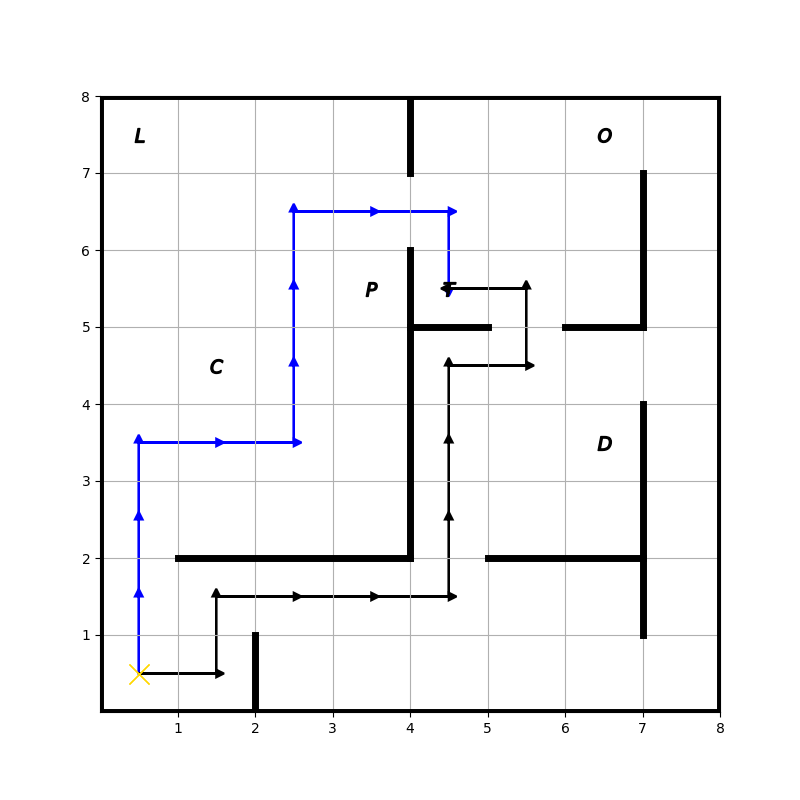

Simulate Trajectories:  29%|████████████████▌                                        | 29/100 [00:00<00:00, 285.03it/s]

Getting model performance!!


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6670.12it/s]

Simulation length = 0.420
Optimal Policy performance:
Cost: 5.524
Legible Reward: 1.553
legible Policy performance:
Cost: 5.524
Legible Reward: 1.834


In [7]:
print('Initial State: ' + x0)
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')

print('Optimal trajectory for task: ' + goal)
t1, a1 = mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory(x0, pol_w)
print('Trajectory: ' + str(t1))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[t1, a1]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward([[t1, a1]])))
t_opt = process_trajectory(t1, a1)

print('Legible trajectory for task: ' + goal)
task_traj, task_act = task_mdp_w.trajectory(x0, task_pol_w)
print('Trajectory: ' + str(task_traj))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[task_traj, task_act]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward([[task_traj, task_act]])))
t_leg = process_trajectory(task_traj, task_act)

fig = create_world_view(n_rows, n_cols, objs_states, walls)
visualize_trajectory(t_opt[0], t_opt, fig, 'b')
visualize_trajectory(t_leg[0], t_leg, fig, 'k')
fig.show()

print('Getting model performance!!')
clock_1 = time.time()
mdp_r, mdp_rl, leg_mdp_r, leg_mdp_rl = simulate(mdps_w['mdp' + str(goals.index(goal) + 1)], pol_w,
                                                task_mdp_w, task_pol_w, x0, 100)
time_simulation = time.time() - clock_1
print('Simulation length = %.3f' % time_simulation)
print('Optimal Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (mdp_r, mdp_rl))
print('legible Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (leg_mdp_r, leg_mdp_rl))

<IPython.core.display.Javascript object>


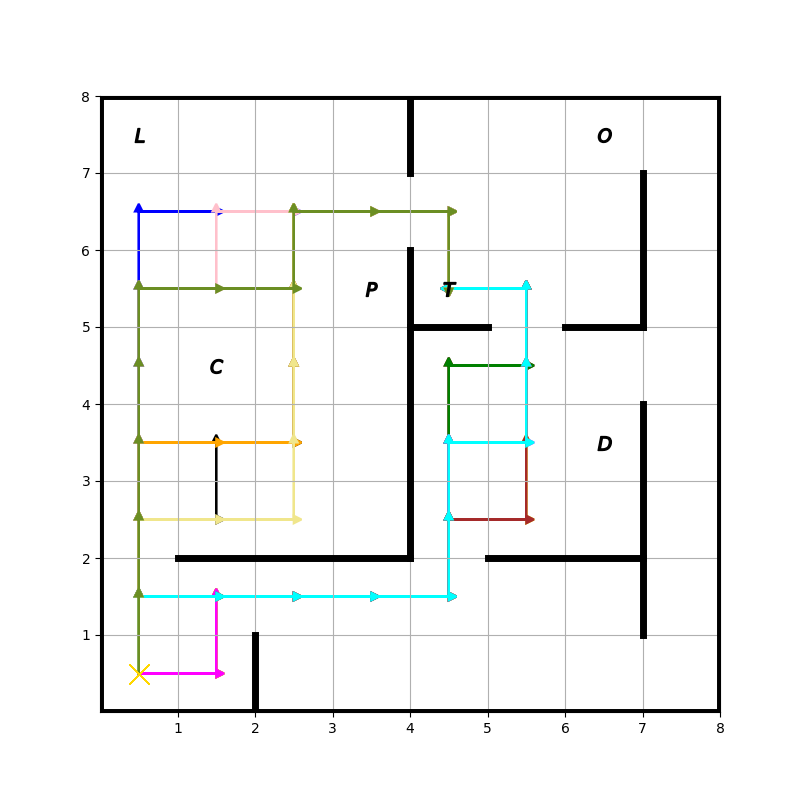

Optimal trajectories: 12


<IPython.core.display.Javascript object>


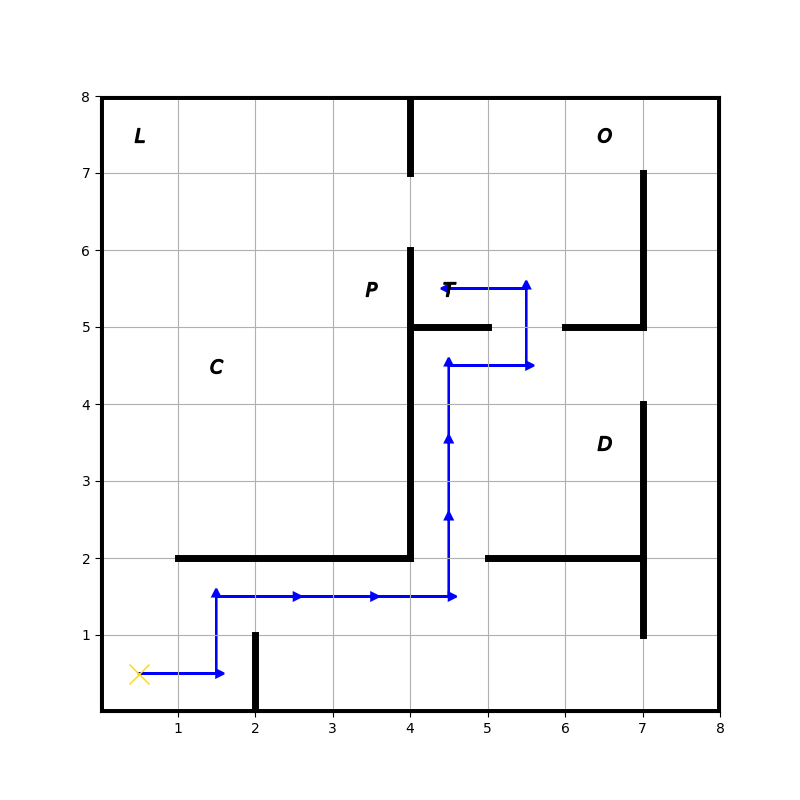

Legible trajectories: 1


In [15]:
trajs, a_trajs = mdps_w['mdp' + str(goals.index(goal) + 1)].all_trajectories(x0, pol_w)
colors = ['blue', 'darkred', 'green', 'black', 'orange', 'pink', 'yellow', 'magenta', 'brown', 'cyan', 'khaki', 'olivedrab', 'lightcoral']
i = 0
fig = create_world_view(n_rows, n_cols, objs_states, walls)
for j in range(len(trajs)):
    traj = trajs[j]
    a_traj = a_trajs[j]
    p_traj = process_trajectory(traj, a_traj)
    visualize_trajectory(p_traj[0], p_traj, fig, colors[min(i, len(colors))])
    i += 1
fig.show()
print('Optimal trajectories: %d' % len(trajs))

leg_trajs, leg_a_trajs = task_mdp_w.all_trajectories(x0, task_pol_w)
i = 0
fig = create_world_view(n_rows, n_cols, objs_states, walls)
for j in range(len(leg_trajs)):
    traj = leg_trajs[j]
    a_traj = leg_a_trajs[j]
    p_traj = process_trajectory(traj, a_traj)
    visualize_trajectory(p_traj[0], p_traj, fig, colors[min(i, len(colors))])
    i += 1
fig.show()
print('Legible trajectories: %d' % len(leg_trajs))

In [10]:
print('Creating demo trajectories')
n_trajs = 100
print('Optimal trajectories')
opt_trajs = []
for _ in range(n_trajs):
    x0 = '1 1 N'
    t1, a1 = mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory(x0, pol_w)
    traj = []
    for i in range(len(t1)):
        traj += [[list(X_w).index(t1[i]), list(A_w).index(a1[i])]]
    opt_trajs += [np.array(traj)]
# print(opt_trajs)
print('Legible trajectories')
leg_trajs = []
for _ in range(n_trajs):
    x0 = '1 1 N'
    traj = []
    task_traj, task_act = task_mdp_w.trajectory(x0, task_pol_w)
    for i in range(len(task_traj)):
        traj += [[list(X_w).index(task_traj[i]), list(A_w).index(task_act[i])]]
    leg_trajs += [np.array(traj)]
# print(leg_trajs)

# for i in range(len(opt_trajs) - 1):
#     for j in range(i, len(opt_trajs)):
#         print((opt_trajs[i] == opt_trajs[j]).all(), end='\t')
#     print('\n')
    
# for i in range(len(leg_trajs) - 1):
#     for j in range(i, len(leg_trajs)):
#         print((leg_trajs[i] == leg_trajs[j]).all(), end='\t')
#     print('\n')

Creating demo trajectories
Optimal trajectories
Legible trajectories


In [13]:
print('######################################')
print('#####     IRL Agent Learning     #####')
print('######################################')

print('IRL Agent')
opt_learner = LearnerMDP(X_w, A_w, P_w, 0.9, costs, -1)
leg_learner = LearnerMDP(X_w, A_w, P_w, 0.9, leg_costs, 1)

# print('Optimal Trajectory')
# for i in indexes:
#     print('Demo size %i' % i)
#     opt_reward, opt_idx = opt_learner.birl_inference(opt_traj[:i], 0.9)
#     leg_reward, leg_idx = leg_learner.birl_inference(opt_traj[:i], 0.9)
#     print(opt_idx, leg_idx)
    
# print('Legible Trajectory')
# for i in indexes:
#     print('Demo size %i' % i)
#     opt_reward, opt_idx = opt_learner.birl_inference(leg_traj[:i], 0.9)
#     leg_reward, leg_idx = leg_learner.birl_inference(leg_traj[:i], 0.9)
#     print(opt_idx, leg_idx)

traj_len = 12
step = 2
print('Optimal trajectory eval')
opt_learner_count = opt_learner.learner_eval(0.9, opt_trajs, traj_len, step, goals.index(goal))
leg_learner_count = leg_learner.learner_eval(0.9, opt_trajs, traj_len, step, goals.index(goal))
print(opt_learner_count/n_trajs, leg_learner_count/n_trajs)

print('Legible trajectory eval')
opt_learner_count = opt_learner.learner_eval(0.9, leg_trajs, traj_len, step, goals.index(goal))
leg_learner_count = leg_learner.learner_eval(0.9, leg_trajs, traj_len, step, goals.index(goal))
print(opt_learner_count/n_trajs, leg_learner_count/n_trajs)

######################################
#####     IRL Agent Learning     #####
######################################
IRL Agent
N. iterations:  9
N. iterations:  10
N. iterations:  9
N. iterations:  11
N. iterations:  9
N. iterations:  11
N. iterations:  7
N. iterations:  6
N. iterations:  6


KeyboardInterrupt: 

In [16]:
print('######################################')
print('#####     IRL Agent Learning     #####')
print('######################################')

print('IRL Agent')
opt_learner = LearnerMDP(X_w, A_w, P_w, 0.9, costs, -1)
leg_learner = LearnerMDP(X_w, A_w, P_w, 0.9, leg_costs, 1)

print('Preparing Trajectories')
p_trajs = []
for i in range(len(trajs)):
    p_traj = []
    traj = trajs[i]
    a_traj = a_trajs[i]
    for j in range(len(traj)):
        p_traj += [[list(X_w).index(traj[j]), list(A_w).index(a_traj[j])]]
    p_trajs +=  [np.array(p_traj)]

p_leg_trajs = []
for i in range(len(leg_trajs)):
    p_traj = []
    traj = leg_trajs[i]
    a_traj = leg_a_trajs[i]
    for j in range(len(traj)):
        p_traj += [[list(X_w).index(traj[j]), list(A_w).index(a_traj[j])]]
    p_leg_trajs +=  [np.array(p_traj)]
    
print('Learning')
indexes = []
traj_len = len(p_trajs[0])
step = 2
for i in range(step, traj_len+1, step):
    indexes += [i]

if traj_len % step == 0:
    n_idx = traj_len // step
else:
    n_idx = traj_len // step + 1
    indexes += [traj_len]
    
#for traj in p_trajs:
for traj in p_leg_trajs:
    for i in range(n_idx):
        idx = indexes[i]
        r, o_idx = opt_learner.birl_inference(traj[:idx], 0.9)
        r, l_idx = leg_learner.birl_inference(traj[:idx], 0.9)
        print(o_idx, l_idx, goals.index(goal))

######################################
#####     IRL Agent Learning     #####
######################################
IRL Agent
N. iterations:  9
N. iterations:  10
N. iterations:  9
N. iterations:  11
N. iterations:  9
N. iterations:  11
N. iterations:  7
N. iterations:  6
N. iterations:  6
N. iterations:  6
N. iterations:  7
N. iterations:  7
Preparing Trajectories
Learning
[[0.20256820395118674, 0.20301073265900071, 0.20163574553769653, 0.203049314997532, 0.20269176442114917, 0.2029794840170114], [0.19849996631854322, 0.19824297652607725, 0.19854573103445547, 0.19822059108847415, 0.1984281674727827, 0.1982611093662127]]
[[0.11996787179347485, 0.2837385303607539, 0.14804434416818826, 0.12663912325137214, 0.251933764108495, 0.23820341896092703], [0.25450842881558733, 0.3370266544005124, 0.2236689237677673, 0.24774715199644676, 0.2936209464330597, 0.27100038443782576]]
1 1 4
[[0.20256820395118674, 0.20301073265900071, 0.20163574553769653, 0.203049314997532, 0.20269176442114917, 0.202979

<IPython.core.display.Javascript object>


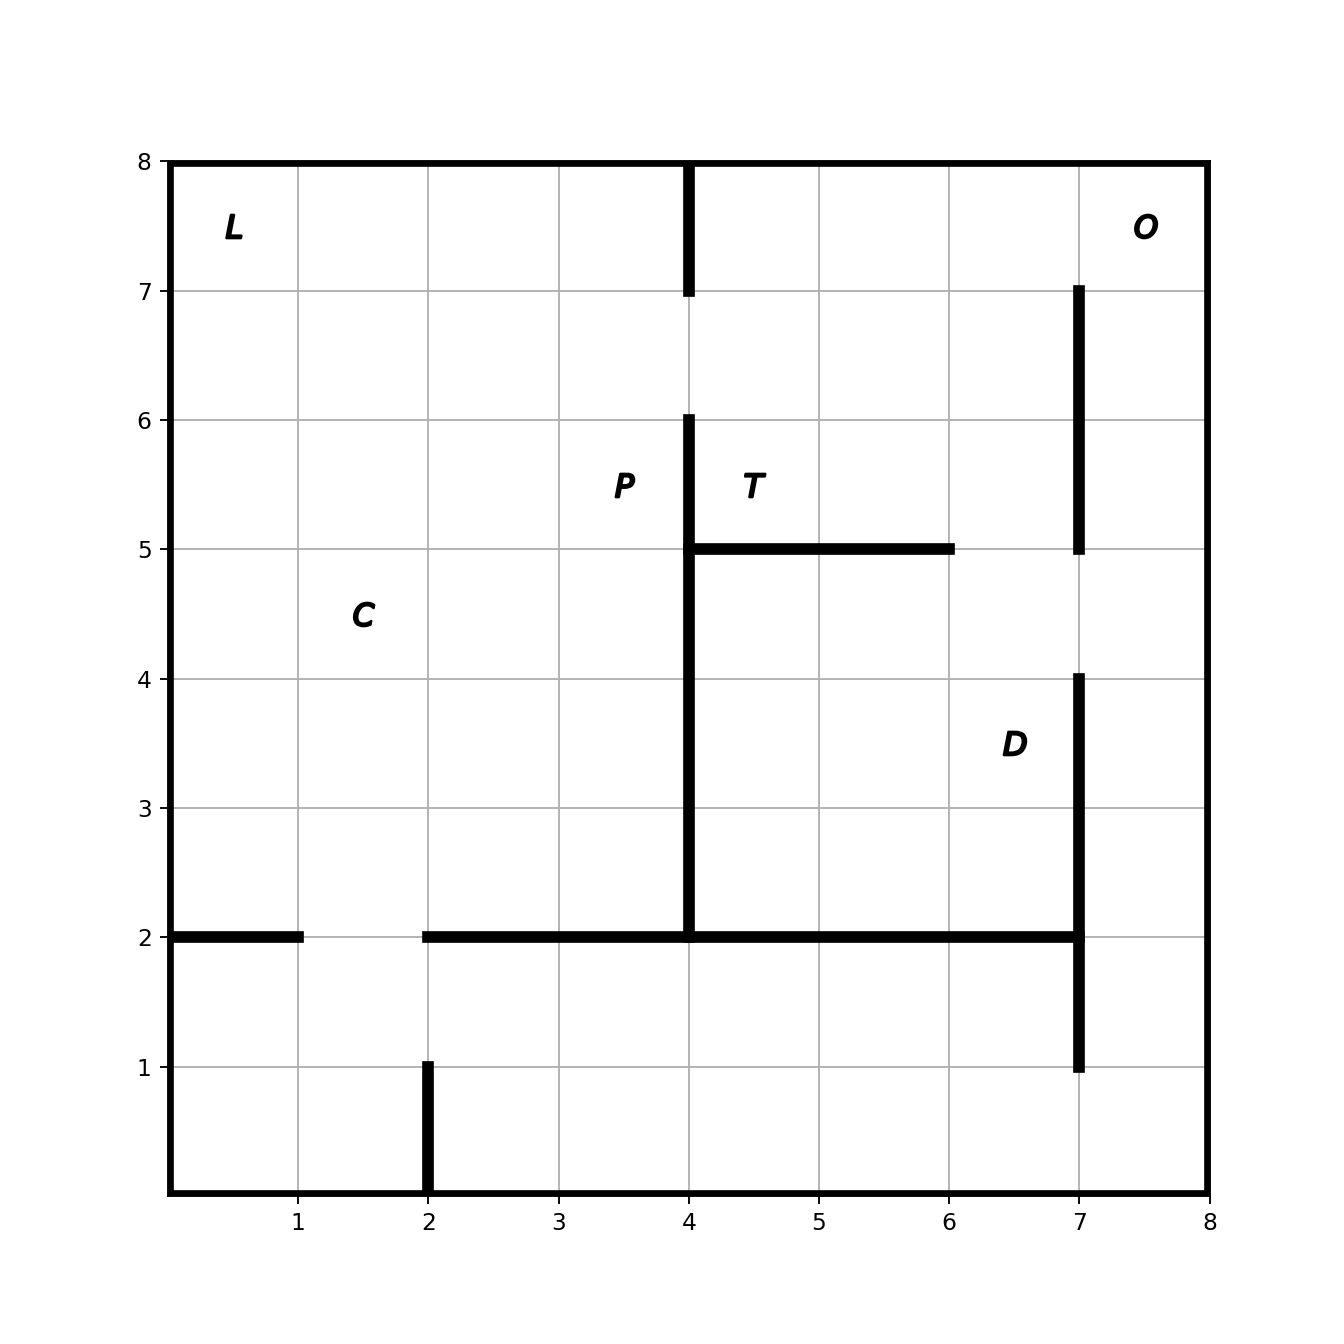

In [9]:
def irl_trajectory(mdp, goal, pol, x0):
    X = mdp[0]
    A = mdp[1]
    P = mdp[2]

    nX = len(X)
    nA = len(A)

    traj = [x0]
    actions = []
    x = list(X).index(x0)
    stop = False

    print(x0)
    while not stop:
        a = np.random.choice(nA, p=pol[x, :])
        x = np.random.choice(nX, p=P[A[a]][x, :])

        print(A[a], X[x])
        
        traj += [X[x]]
        actions += [A[a]]

        stop = (X[x].find(goal) != -1)
        if stop:
            actions += [A[np.random.choice(nA, p=pol[x, :])]]

    return np.array(traj), np.array(actions)

fig = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [13]:
x0 = '1 1 N'
print('Optimal irl trajectory for task: ' + goal)
t1, a1 = irl_trajectory(opt_learner_w.mdp_r, goal, pol_irl_ow, x0)
print('Trajectory: ' + str(t1))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[t1, a1]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward([[t1, a1]])))
t_opt = process_trajectory(t1, a1)

print('Legible irl trajectory for task: ' + goal)
task_traj, task_act = irl_trajectory(leg_learner_w.mdp_r, goal, pol_irl_lw, x0)
print('Trajectory: ' + str(task_traj))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[task_traj, task_act]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward([[task_traj, task_act]])))
t_leg = process_trajectory(task_traj, task_act)

fig = create_world_view(n_rows, n_cols, objs_states, walls)
visualize_trajectory(t_opt[0], t_opt, fig, 'b')
visualize_trajectory(t_leg[0], t_leg, fig, 'k')
fig.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 986.66it/s]

Optimal irl trajectory for task: D
1 1 N
R 1 2 N
D 2 2 N
D 3 2 N
D 4 2 N
R 4 3 N
D 5 3 N
D 6 3 N
D 7 3 N
R 7 4 N
R 7 5 N
R 7 6 N
R 7 7 N
U 6 7 N
U 5 7 N
U 4 7 D
Trajectory: ['1 1 N' '1 2 N' '2 2 N' '3 2 N' '4 2 N' '4 3 N' '5 3 N' '6 3 N' '7 3 N'
 '7 4 N' '7 5 N' '7 6 N' '7 7 N' '6 7 N' '5 7 N' '4 7 D']
Cost: 4.039174716891639
Legible Reward: 0.900424497114076
Legible irl trajectory for task: D
1 1 N
R 1 2 N
D 2 2 N
R 2 3 N
R 2 4 N
U 1 4 N
R 1 5 N
R 1 6 N
R 1 7 N
R 1 8 N
D 2 8 N
D 3 8 N
D 4 8 N
D 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8

R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N


R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N


R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N


R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N


R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N


R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N


R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N


R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N


L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N


R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R 5 8 N
L 5 7 N
R

KeyboardInterrupt: 

In [ ]:
print('######################################')
print('#####   Auto Collect Maze World  #####')
print('######################################')
print('### Generating World ###')
acmw = AutoCollectMazeWord()
X_a, A_a, P_a = acmw.generate_world(n_rows, n_cols, objs_states)

print('### Computing Costs and Creating Task MDPs ###')
mdps_a = {}
for i in tqdm(range(len(goals)), desc='Single Task MDPs'):
    c = acmw.generate_costs_varied(goals[i], X_a, A_a, P_a)
    mdp = MDP(X_a, A_a, P_a, c, 0.9, get_goal_states(X_a, goals[i]))
    mdps_a['mdp' + str(i + 1)] = mdp
print('Legible task MDP')
task_mdp_a = LegibleTaskMDP(X_a, A_a, P_a, 0.9, goal, goals, list(mdps_a.values()), 2.0,
                            get_goal_states(X_a, goal))

print('### Computing Optimal policy ###')
time1 = time.time()
pol_l, Q1 = mdps_l['mdp' + str(goals.index(goal) + 1)].policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

print('### Computing Legible policy ###')
time1 = time.time()
task_pol_l, task_Q = task_mdp_l.policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

In [9]:
print('Initial State: ' + x0)
print('######################################')
print('#####   Auto Collect Maze World  #####')
print('######################################')

print('Optimal trajectory for task: ' + goal)
t1, a1 = mdps_a['mdp' + str(goals.index(goal) + 1)].trajectory(x0, pol_a)
print('Trajectory: ' + str(t1))
print('Reward: ' + str(mdps_a['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[t1, a1]])))
print('Legible Reward: ' + str(task_mdp_a.trajectory_reward([[t1, a1]])))
t_opt = process_trajectory(t1, a1)

print('Legible trajectory for task: ' + goal)
task_traj, task_act = task_mdp_a.trajectory(x0, task_pol_a)
print('Trajectory: ' + str(task_traj))
print('Reward: ' + str(mdps_a['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[task_traj, task_act]])))
print('Legible Reward: ' + str(task_mdp_a.trajectory_reward([[task_traj, task_act]])))
t_leg = process_trajectory(task_traj, task_act)

fig = create_world_view(n_rows, n_cols, objs_states)
visualize_trajectory(t_opt[0], t_opt, fig, 'b')
visualize_trajectory(t_leg[0], t_leg, fig, 'k')
fig.show()

print('Getting model performance!!')
clock_1 = time.time()
mdp_r, mdp_rl, leg_mdp_r, leg_mdp_rl = simulate(mdps_a['mdp' + str(goals.index(goal) + 1)], pol_a,
                                                task_mdp_a, task_pol_a, x0, 100)
time_simulation = time.time() - clock_1
print('Simulation length = %.3f' % time_simulation)
print('Optimal Policy performance:\nReward: %.3f\nLegible Reward: %.3f' % (mdp_r, mdp_rl))
print('legible Policy performance:\nReward: %.3f\nLegible Reward: %.3f' % (leg_mdp_r, leg_mdp_rl))

Initial State: 1 1 N
######################################
#####   Auto Collect Maze World  #####
######################################
Optimal trajectory for task: PDO


NameError: name 'mdps_a' is not defined

In [ ]:
print('#######################################')
print('#####   Limit Collect Maze World  #####')
print('#######################################')
print('### Generating World ###')
cmw = LimitedCollectMazeWorld()
X_l, A_l, P_l = cmw.generate_world(n_rows, n_cols, objs_states)

print('### Computing Costs and Creating Task MDPs ###')
mdps_l = {}
for i in range(len(goals)):
    c = cmw.generate_costs_varied(goals[i], X_l, A_l, P_l)
    mdp = MDP(X_l, A_l, P_l, c, 0.9, get_goal_states(X_l, goals[i]))
    mdps_l['mdp' + str(i+1)] = mdp
task_mdp_l = LegibleTaskMDP(X_l, A_l, P_l, 0.9, goal, goals, list(mdps_l.values()), 2.0, get_goal_states(X_l, goal))

print('### Computing Optimal policy ###')
time1 = time.time()
pol_l, Q1 = mdps_l['mdp' + str(goals.index(goal) + 1)].policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

print('### Computing Legible policy ###')
time1 = time.time()
task_pol_l, task_Q = task_mdp_l.policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

In [ ]:
print('#######################################')
print('#####   Limit Collect Maze World  #####')
print('#######################################')

print('Optimal trajectory for task: ' + goal)
t1, a1 = mdps_l['mdp' + str(goals.index(goal) + 1)].trajectory(x0, pol_l)
print(t1)
t_opt = process_trajectory(t1, a1)

print('Legible trajectory for task: ' + goal)
task_traj, task_act = task_mdp_l.trajectory(x0, task_pol_l)
print(task_traj)
t_leg = process_trajectory(task_traj, task_act)

fig2 = create_world_view(n_rows, n_cols, objs_states)
visualize_trajectory(t_opt[0], t_opt, fig2, 'b')
visualize_trajectory(t_leg[0], t_leg, fig2, 'k')
fig2.show()

print('Getting model performance!!')
clock_1 = time.time()
mdp_r, mdp_rl, leg_mdp_r, leg_mdp_rl = simulate(mdps_l['mdp' + str(goals.index(goal) + 1)], pol_l,
                                                task_mdp_l, task_pol_l, x0, 10)
time_simulation = time.time() - clock_1
print('Simulation length = %.3f' % time_simulation)
print('Optimal Policy performance:\nReward: %.3f\nLegible Reward: %.3f' % (mdp_r, mdp_rl))
print('legible Policy performance:\nReward: %.3f\nLegible Reward: %.3f' % (leg_mdp_r, leg_mdp_rl))

In [30]:
n_rows = 4
n_cols = 3
objs_states = [(2, 3, 'P'), (2, 1, 'D')]
walls = [[(0.5, x + 0.5) for x in range(0, n_cols + 1)],
         [(n_rows + 0.5, x + 0.5) for x in range(0, n_cols + 1)], 
         [(x + 0.5, 0.5) for x in range(0, n_rows + 1)], 
         [(x + 0.5, n_cols + 0.5) for x in range(0, n_rows + 1)], 
         [(1.5, x + 0.5) for x in range(0, 2)],
         [(1.5, x + 0.5) for x in range(2, 4)],
         [(x + 0.5, 1.5) for x in range(1, 4)],
         [(x + 0.5, 2.5) for x in range(1, 4)],]
# x0 = np.random.choice([x for x in X_a if 'N' in x])
x0 = '1 1 N'
goals = ['P', 'D']
goal = 'D'

<IPython.core.display.Javascript object>


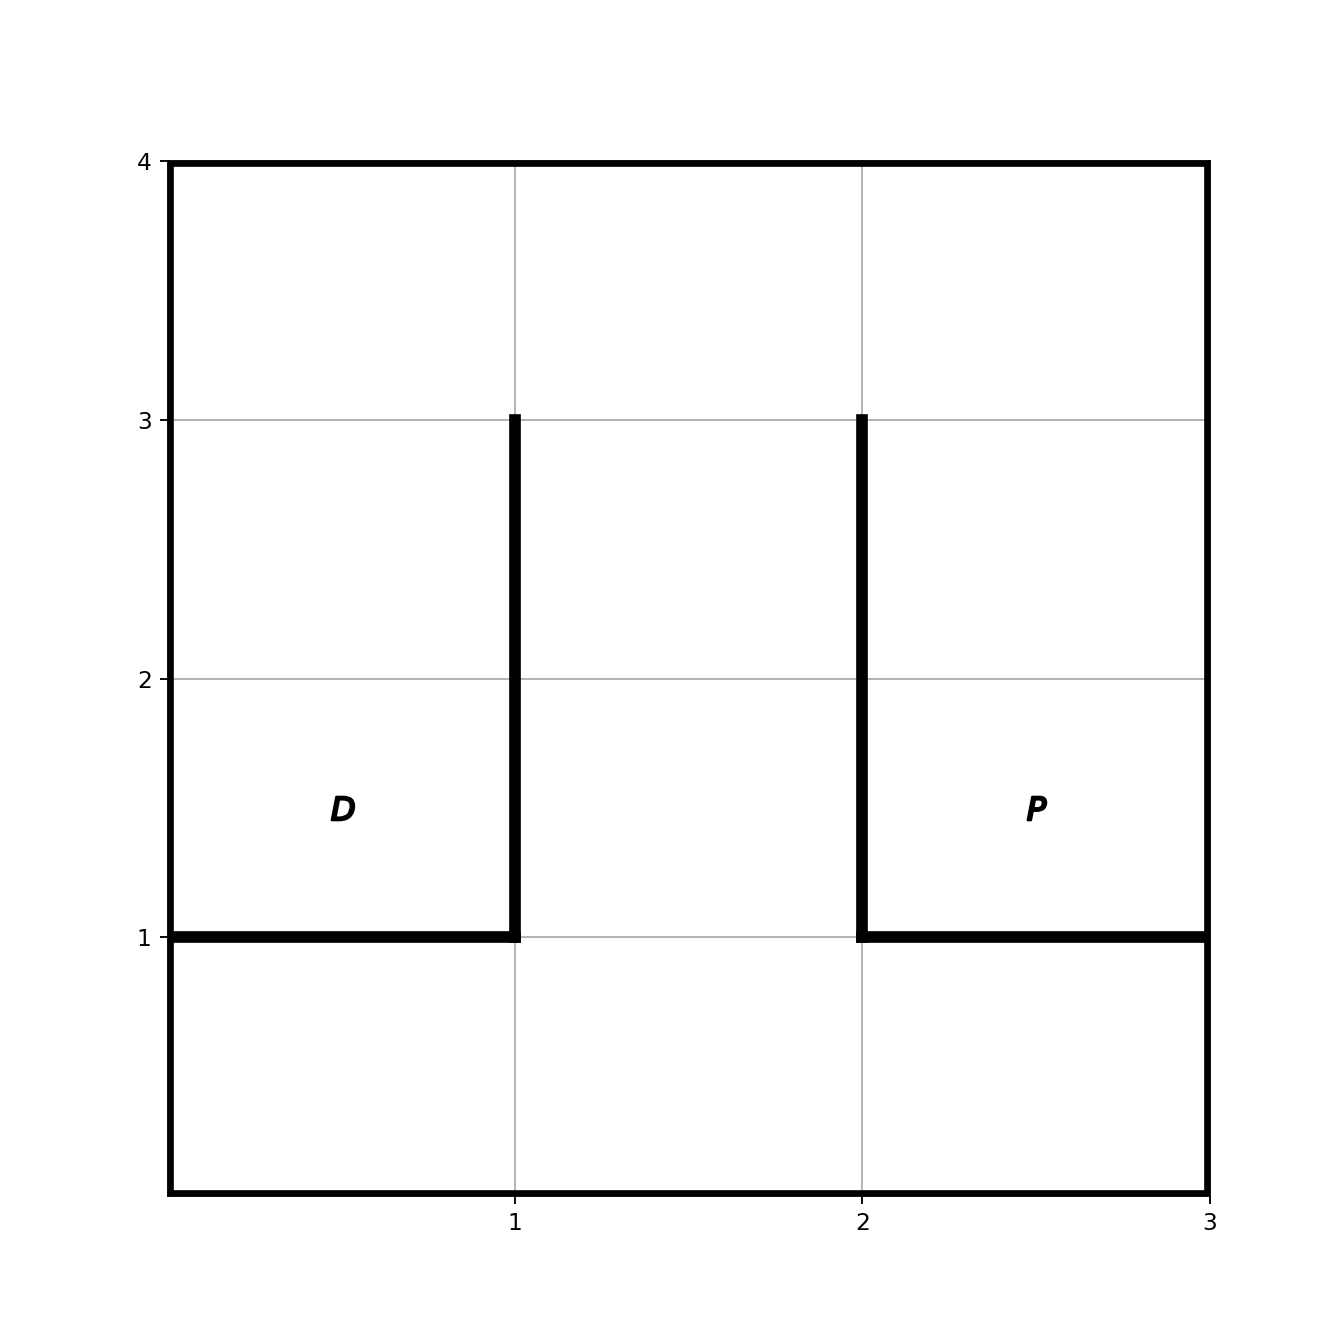

In [31]:
fig = create_world_view(n_rows, n_cols, objs_states, walls)
fig.show()

In [32]:
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')
wacmw = WallAutoCollectMazeWorld()
X_w, A_w, P_w = wacmw.generate_world(n_rows, n_cols, objs_states, walls)

print('### Computing Costs and Creating Task MDPs ###')
mdps_w = {}
q_mdps_w = []
task_mdps_w = {}
costs = []
for i in tqdm(range(len(goals)), desc='Single Task MDPs'):
    c = wacmw.generate_costs_varied(goals[i], X_w, A_w, P_w)
    costs += [c]
    mdp = MDP(X_w, A_w, P_w, c, 0.9, get_goal_states(X_w, goals[i]))
    _, q = mdp.policy_iteration()
    q_mdps_w += [q]
    mdps_w['mdp' + str(i + 1)] = mdp
print('Legible task MDP')
leg_costs = []
for i in tqdm(range(len(goals)), desc='Legible Task MDPs'):
    mdp = LegibleTaskMDP(X_w, A_w, P_w, 0.9, goals[i], goals, 2.0, get_goal_states(X_w, goals[i]),
                         # task_mdps=list(mdps_w.values()))
                         q_mdps=q_mdps_w)
    leg_costs += [mdp.costs]
    task_mdps_w['leg_mdp_' + str(i + 1)] = mdp
task_mdp_w = task_mdps_w['leg_mdp_' + str(goals.index(goal) + 1)]

print('### Computing Optimal policy ###')
time1 = time.time()
pol_w, Q1 = mdps_w['mdp' + str(goals.index(goal) + 1)].policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

print('### Computing Legible policy ###')
time1 = time.time()
task_pol_w, task_Q = task_mdp_w.policy_iteration()
print('Took %.3f seconds to compute policy' % (time.time() - time1))

Legible Task MDPs: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 667.14it/s]

##########################################
#####  Wall Auto Collect Maze World  #####
##########################################
### Computing Costs and Creating Task MDPs ###
N. iterations:  2
N. iterations:  2
Legible task MDP
### Computing Optimal policy ###
N. iterations:  2
Took 0.022 seconds to compute policy
### Computing Legible policy ###
N. iterations:  3
Took 0.028 seconds to compute policy


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Initial State: 1 1 N
##########################################
#####  Wall Auto Collect Maze World  #####
##########################################
Optimal trajectory for task: D
Trajectory: ['1 1 N' '1 2 N' '2 2 N' '3 2 N' '4 2 N' '4 1 N' '3 1 N' '2 1 D']
Cost: 4.226768900000001
Legible Reward: 3.901655903651401
Legible trajectory for task: D
Trajectory: ['1 1 N' '1 2 N' '2 2 N' '3 2 N' '4 2 N' '4 1 N' '3 1 N' '2 1 D']
Cost: 4.226768900000001
Legible Reward: 3.901655903651401


<IPython.core.display.Javascript object>


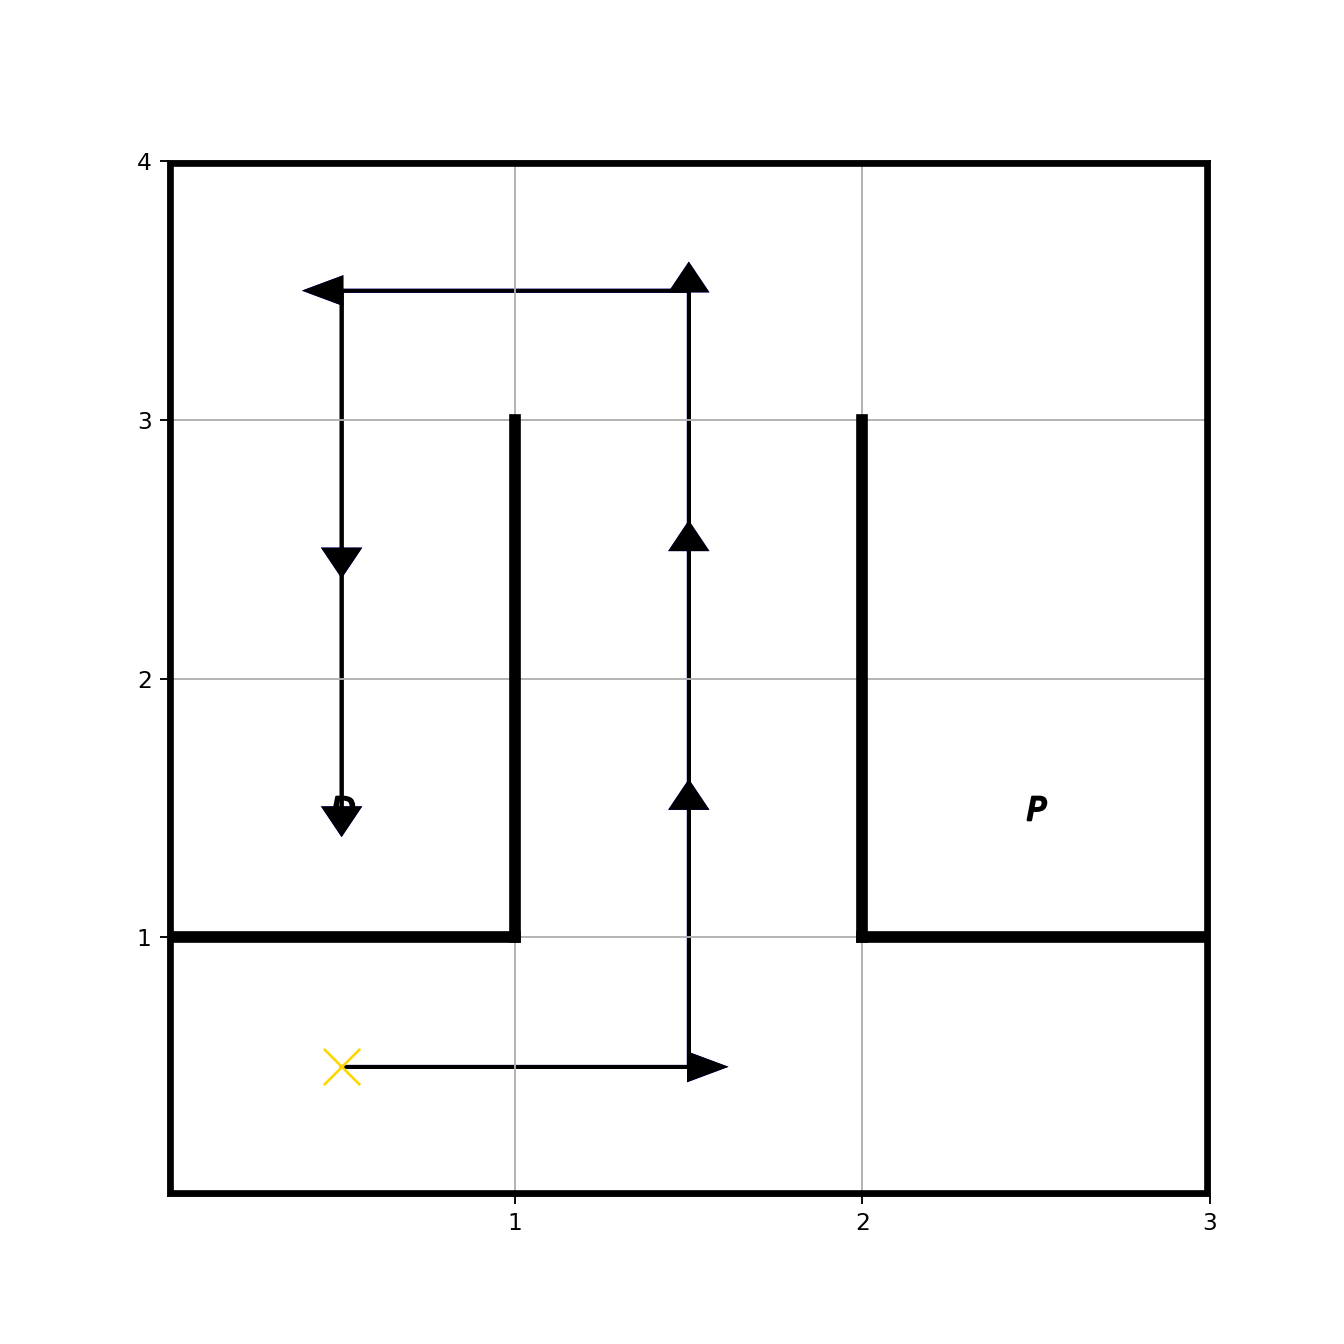

Simulate Trajectories:  73%|█████████████████████████████████████████▌               | 73/100 [00:00<00:00, 729.99it/s]

Getting model performance!!


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 50009.59it/s]

Simulation length = 0.172
Optimal Policy performance:
Cost: 4.227
Legible Reward: 3.902
legible Policy performance:
Cost: 4.227
Legible Reward: 3.902


In [33]:
print('Initial State: ' + x0)
print('##########################################')
print('#####  Wall Auto Collect Maze World  #####')
print('##########################################')

print('Optimal trajectory for task: ' + goal)
t1, a1 = mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory(x0, pol_w)
print('Trajectory: ' + str(t1))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[t1, a1]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward([[t1, a1]])))
t_opt = process_trajectory(t1, a1)

print('Legible trajectory for task: ' + goal)
task_traj, task_act = task_mdp_w.trajectory(x0, task_pol_w)
print('Trajectory: ' + str(task_traj))
print('Cost: ' + str(mdps_w['mdp' + str(goals.index(goal) + 1)].trajectory_reward([[task_traj, task_act]])))
print('Legible Reward: ' + str(task_mdp_w.trajectory_reward([[task_traj, task_act]])))
t_leg = process_trajectory(task_traj, task_act)

fig = create_world_view(n_rows, n_cols, objs_states, walls)
visualize_trajectory(t_opt[0], t_opt, fig, 'b')
visualize_trajectory(t_leg[0], t_leg, fig, 'k')
fig.show()

print('Getting model performance!!')
clock_1 = time.time()
mdp_r, mdp_rl, leg_mdp_r, leg_mdp_rl = simulate(mdps_w['mdp' + str(goals.index(goal) + 1)], pol_w,
                                                task_mdp_w, task_pol_w, x0, 100)
time_simulation = time.time() - clock_1
print('Simulation length = %.3f' % time_simulation)
print('Optimal Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (mdp_r, mdp_rl))
print('legible Policy performance:\nCost: %.3f\nLegible Reward: %.3f' % (leg_mdp_r, leg_mdp_rl))

In [23]:
print('######################################')
print('#####     IRL Agent Learning     #####')
print('######################################')

print('IRL Agent')
opt_learner = LearnerMDP(X_w, A_w, P_w, 0.9, costs, -1)
leg_learner = LearnerMDP(X_w, A_w, P_w, 0.9, leg_costs, 1)

print('Preparing Trajectories')
p_traj = []
for j in range(len(t1)):
    p_traj += [[list(X_w).index(t1[j]), list(A_w).index(a1[j])]]
p_traj =  np.array(p_traj)

print('Learning')
indexes = []
traj_len = len(p_traj)
step = 2
for i in range(step, traj_len+1, step):
    indexes += [i]

if traj_len % step == 0:
    n_idx = traj_len // step
else:
    n_idx = traj_len // step + 1
    indexes += [traj_len]
    
for i in tqdm(range(n_idx)):
    idx = indexes[i]
    r, o_idx = opt_learner.birl_inference(p_traj[:idx], 0.9)
    r, l_idx = leg_learner.birl_inference(p_traj[:idx], 0.9)
    print(o_idx, l_idx, goals.index(goal))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 41.67it/s]

######################################
#####     IRL Agent Learning     #####
######################################
IRL Agent
N. iterations:  4
N. iterations:  4
N. iterations:  3
N. iterations:  3
Preparing Trajectories
Learning
1 0 1
0 1 1
1 1 1
1 1 1


In [38]:
print('######################################')
print('#####     IRL Agent Learning     #####')
print('######################################')

print('IRL Agent')
opt_learner = LearnerMDP(X_w, A_w, P_w, 0.9, costs, -1)
leg_learner = LearnerMDP(X_w, A_w, P_w, 0.9, leg_costs, 1)

print('Preparing Trajectories')
p_traj = []
for j in range(len(t1)):
    p_traj += [[list(X_w).index(t1[j]), list(A_w).index(a1[j])]]
p_traj =  np.array(p_traj)

print('Learning')
indexes = []
traj_len = len(p_traj)
step = 2
for i in range(step, traj_len+1, step):
    indexes += [i]

if traj_len % step == 0:
    n_idx = traj_len // step
else:
    n_idx = traj_len // step + 1
    indexes += [traj_len]
    
for i in tqdm(range(n_idx)):
    idx = indexes[i]
    r, o_idx = opt_learner.birl_inference(p_traj[:idx], 0.9)
    r, l_idx = leg_learner.birl_inference(p_traj[:idx], 0.9)
    print(o_idx, l_idx, goals.index(goal))

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1346.05it/s]

######################################
#####     IRL Agent Learning     #####
######################################
IRL Agent
N. iterations:  4
N. iterations:  4
N. iterations:  3
N. iterations:  3
Preparing Trajectories
Learning
0 1 1
0 1 1
1 1 1
1 1 1
